In [1]:
import numpy as np
from scipy.spatial.distance import directed_hausdorff, jensenshannon
from scipy.stats import wasserstein_distance
from matplotlib import pyplot as plt
import matplotlib.patches as patches
import time
%matplotlib inline

In [2]:
import numpy as np
import matplotlib.pyplot as plt


def sample_inhomogeneous_poisson(lambda_max, lambda_func, T):
    """
    Samples from an inhomogeneous Poisson process.

    Parameters:
    - lambda_max: Maximum value of the intensity function (over the interval [0, T]).
    - lambda_func: Intensity function λ(t), should take a single argument t and return λ(t).
    - T: End time of the process.

    Returns:
    - times: Array of event times.
    """
    # Step 1: Sample from a homogeneous Poisson process with rate lambda_max
    n_samples = np.random.poisson(lambda_max * T)
    uniform_times = np.random.uniform(0, T, size=n_samples)
    uniform_times.sort()  # Sort times to maintain temporal order
    
    # Step 2: Thinning step
    acceptance_probabilities = lambda_func(uniform_times) / lambda_max
    accepted = np.random.uniform(0, 1, size=n_samples) < acceptance_probabilities
    times = uniform_times[accepted]
    
    return times




In [3]:
def rate_function(t, rate, N):
    r1 = N*rate
    r2 = N/rate
    t_ = 1/(1+rate)
    # print(t_)
    r = np.zeros_like(t)
    r[t<t_] = r1
    r[t>=t_] = r2
    return r

In [4]:
def JS_div(data1, data2, bins=10, eps=1e-5):
    x_min = min(np.min(data1), np.min(data2)) - eps
    x_max = max(np.max(data1), np.max(data2)) + eps
    h1, bin_edges = np.histogram(data1, bins=bins, range=(x_min, x_max))
    h2, bin_edges = np.histogram(data2, bins=bins, range=(x_min, x_max))
    p1 = h1/len(data1)
    p2 = h2/len(data2)
    return jensenshannon(p1, p2)**2

def hausdorff_distance_np(arr1, arr2, return_values=False):
    arr1 = np.asarray(arr1)
    arr2 = np.asarray(arr2)
    distances = np.abs(arr1[:, None] - arr2[None, :])
    forward = np.max(np.min(distances, axis=1))
    backward = np.max(np.min(distances, axis=0))
    if return_values:
        return max(forward, backward), np.array([forward, backward])
    return max(forward, backward)

In [5]:
N = 100
T = 1
num_trials = 1000
max_offset = 2
max_rate = 2
offset_list = np.linspace(-max_offset,max_offset,21)
rate_list = np.exp(np.linspace(-max_rate,max_rate,21))

haus_list = np.zeros((len(offset_list), len(rate_list), num_trials))
wass_list = np.zeros((len(offset_list), len(rate_list), num_trials))
JS_list = np.zeros((len(offset_list), len(rate_list), num_trials))
sorted_data1_list = []
sorted_data2_list = []

start_time = time.time()
for i, offset in enumerate(offset_list):
    for j, rate in enumerate(rate_list):
        for k in range(num_trials):
            # data1 = np.random.rand(N,1)
            # data2 = cdf_inv(np.random.rand(N,1), rate) + offset

            # from inhomogeneous poisson
            data1 = sample_inhomogeneous_poisson(N, lambda t: rate_function(t, 1, N), T)
            data2 = sample_inhomogeneous_poisson(max(rate, 1/rate)*N, lambda t: rate_function(t, rate, N), T) + offset
            
            haus_list[i,j,k] = hausdorff_distance_np(data1, data2)
            #print(time.time() - start_time)
            wass_list[i,j,k] = wasserstein_distance(data1, data2)
            #print(time.time() - start_time)
            JS_list[i,j,k] = JS_div(data1, data2)
            #print(time.time() - start_time)

            sorted_data1_list.append(np.sort(data1))
            sorted_data2_list.append(np.sort(data2))

In [6]:
mean_haus = np.mean(haus_list, axis=-1)
mean_wass = np.mean(wass_list, axis=-1)
mean_JS = np.mean(JS_list, axis=-1)

In [7]:
sorted_data1_arr = np.asarray(sorted_data1_list, dtype=object)
sorted_data2_arr = np.asarray(sorted_data2_list, dtype=object)

sorted_data1_arr = sorted_data1_arr.reshape(len(offset_list), len(rate_list), num_trials)
sorted_data2_arr = sorted_data2_arr.reshape(len(offset_list), len(rate_list), num_trials)

In [8]:
datalen1 = np.zeros((len(offset_list), len(rate_list), num_trials))
datalen2 = np.zeros((len(offset_list), len(rate_list), num_trials))

for i, offset in enumerate(offset_list):
    for j, rate in enumerate(rate_list):
        for k in range(num_trials):
            datalen1[i,j,k] = len(sorted_data1_arr[i,j,k])
            datalen2[i,j,k] = len(sorted_data2_arr[i,j,k])

In [10]:
q50 = np.zeros((len(offset_list), len(rate_list), num_trials))
q25 = np.zeros((len(offset_list), len(rate_list), num_trials))
q10 = np.zeros((len(offset_list), len(rate_list), num_trials))
q1 = np.zeros((len(offset_list), len(rate_list), num_trials))

cutlen = 55
data1_cut = np.zeros((cutlen, len(offset_list), len(rate_list), num_trials))
data2_cut = np.zeros((cutlen, len(offset_list), len(rate_list), num_trials))
for i, offset in enumerate(offset_list):
    for j, rate in enumerate(rate_list):
        for k in range(num_trials):
            data1_cut[:,i,j,k] = sorted_data1_arr[i,j,k][:cutlen]
            data2_cut[:,i,j,k] = sorted_data2_arr[i,j,k][:cutlen]
            
            q50[i,j,k] = abs(sorted_data1_arr[i,j,k][49] - sorted_data2_arr[i,j,k][49])
            q25[i,j,k] = abs(sorted_data1_arr[i,j,k][24] - sorted_data2_arr[i,j,k][24])
            q10[i,j,k] = abs(sorted_data1_arr[i,j,k][9] - sorted_data2_arr[i,j,k][9])
            q1[i,j,k] = abs(sorted_data1_arr[i,j,k][0] - sorted_data2_arr[i,j,k][0])

In [11]:
mean_sample_dist = np.abs(data1_cut - data2_cut).mean(axis=-1)

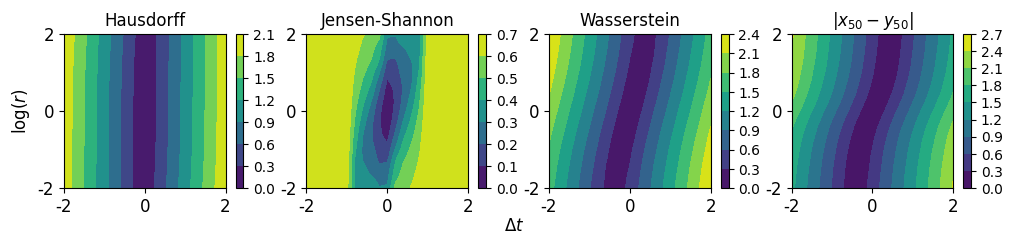

In [12]:
X, Y = np.meshgrid(offset_list, np.log(rate_list))

fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(12,2))
cp = axes[0].contourf(X, Y, mean_haus[:,:].T, cmap='viridis')
fig.colorbar(cp, ax=axes[0])
axes[0].set_title('Hausdorff')
# axes[0].set_xlabel('offset')
axes[0].set_xticks([-2,0,2], [-2,0,2], fontsize=12)
axes[0].set_yticks([-2,0,2], [-2,0,2], fontsize=12)
axes[0].set_ylabel(r'$\log(r)$', fontsize=12)

cp = axes[1].contourf(X, Y, mean_JS[:,:].T, cmap='viridis')
fig.colorbar(cp, ax=axes[1])
axes[1].set_title('Jensen-Shannon')
axes[1].set_yticks([-2,0,2], [-2,0,2], fontsize=12)
axes[1].set_xticks([-2,0,2], [-2,0,2], fontsize=12)
# axes[2].set_xlabel('offset')
# axes[2].set_ylabel('log(rate)')

cp = axes[2].contourf(X, Y, mean_wass[:,:].T, cmap='viridis')
fig.colorbar(cp, ax=axes[2])
axes[2].set_title('Wasserstein')
axes[2].set_xticks([-2,0,2], [-2,0,2], fontsize=12)
axes[2].set_yticks([-2,0,2], [-2,0,2], fontsize=12)
# axes[2].set_xlabel(r'$\Delta t$', fontsize=12)
# axes[1].set_ylabel('log(rate)')

cp = axes[3].contourf(X, Y, mean_sample_dist[50,:,:].T, cmap='viridis')
fig.colorbar(cp, ax=axes[3])
axes[3].set_title(r'$|x_{50} - y_{50}|$')
axes[3].set_xticks([-2,0,2], [-2,0,2], fontsize=12)
axes[3].set_yticks([-2,0,2], [-2,0,2], fontsize=12)
# axes[3].set_xlabel(r'$\Delta t$', fontsize=12)
# axes[1].set_ylabel('log(rate)')

fig.text(0.5, -0.08, r'$\Delta t$', ha='center', va='center', fontsize=12)


# plt.savefig('./example_distance.pdf', format='pdf', bbox_inches="tight", dpi=300)
plt.show()